In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer 


from models.text.nb import multinomialNaiveBayes

from models.text.svm import svm
from models.text.svm import svm_rbf
from models.text.svm import svm_rbf_c

from helper.helper import confusionMatrixHeatmap



[nltk_data] Downloading package stopwords to /home/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('./dataset/book-full-listing-train.csv')
df_test = pd.read_csv('./dataset/book-full-listing-test.csv')
# df = pd.read_csv('./dataset/books-listing-train.csv')
# df_test = pd.read_csv('./dataset/books-listing-test.csv')


In [4]:
df.shape[0]

70190

In [5]:
df['Category'].value_counts()

Category
Travel                       16504
Children's Books             12244
Science & Math                8348
Cookbooks, Food & Wine        7922
Computers & Technology        7181
Sports & Outdoors             5371
Romance                       3862
Science Fiction & Fantasy     3420
Comics & Graphic Novels       2723
Test Preparation              2615
Name: count, dtype: int64

In [6]:
df_test.shape[0]

7801

In [7]:
df_test['Category'].value_counts()

Category
Travel                       1834
Children's Books             1361
Science & Math                928
Cookbooks, Food & Wine        880
Computers & Technology        798
Sports & Outdoors             597
Romance                       429
Science Fiction & Fantasy     380
Comics & Graphic Novels       303
Test Preparation              291
Name: count, dtype: int64

In [8]:
df.drop(['Amazon ID (ASIN)','Filename','Image URL'],axis=1,inplace=True)
df_test.drop(['Amazon ID (ASIN)','Filename','Image URL'],axis=1,inplace=True)

In [9]:
def review_to_words(raw_review): 
    review = raw_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))


In [11]:
corpus= []
for i in range(0, len(df.index)):
    corpus.append(review_to_words(df['Title'][i]))

In [12]:
corpus_test= []
for i in range(0, len(df_test.index)):
    corpus_test.append(review_to_words(df_test['Title'][i]))

In [13]:
df['New_Title']=corpus

In [58]:
df_test['New_Title']=corpus_test

In [14]:
df.head()

,Title,Author,Category ID,Category,New_Title
0,"Alvin Ho: Allergic to Camping, Hiking, and Oth...",Lenore Look,23,Science & Math,alvin ho allergic camping hiking natural disaster
1,Kissed By The Devil,Dashawn Taylor,22,Romance,kissed devil
2,Fodor's Arizona & the Grand Canyon 2015 (Full-...,Fodor's,29,Travel,fodor arizona grand canyon full color travel g...
3,What Is Islam? Who Are Muslims (It's Happening...,Carole Marsh,4,Children's Books,islam muslim happening u
4,Sole Support,Kaje Harper,22,Romance,sole support


# Wordcloud show most usage words

In [15]:
wordCloudList= []

In [ ]:
def generateWordCloud(split_word):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(split_word)
    wordCloudList.append(np.array(wordcloud))

In [ ]:
df['Category'].unique()

array(['Science & Math', 'Romance', 'Travel', "Children's Books",
       'Cookbooks, Food & Wine', 'Sports & Outdoors',
       'Computers & Technology', 'Test Preparation',
       'Science Fiction & Fantasy', 'Comics & Graphic Novels'],
      dtype=object)

In [ ]:
# len(wordCloudList)

10

In [ ]:
for i in df['Category'].unique():
    category=df[df['Category']==i]
    words = ' '.join(category['New_Title'])
    split_word = " ".join([word for word in words.split()])
    generateWordCloud(split_word)


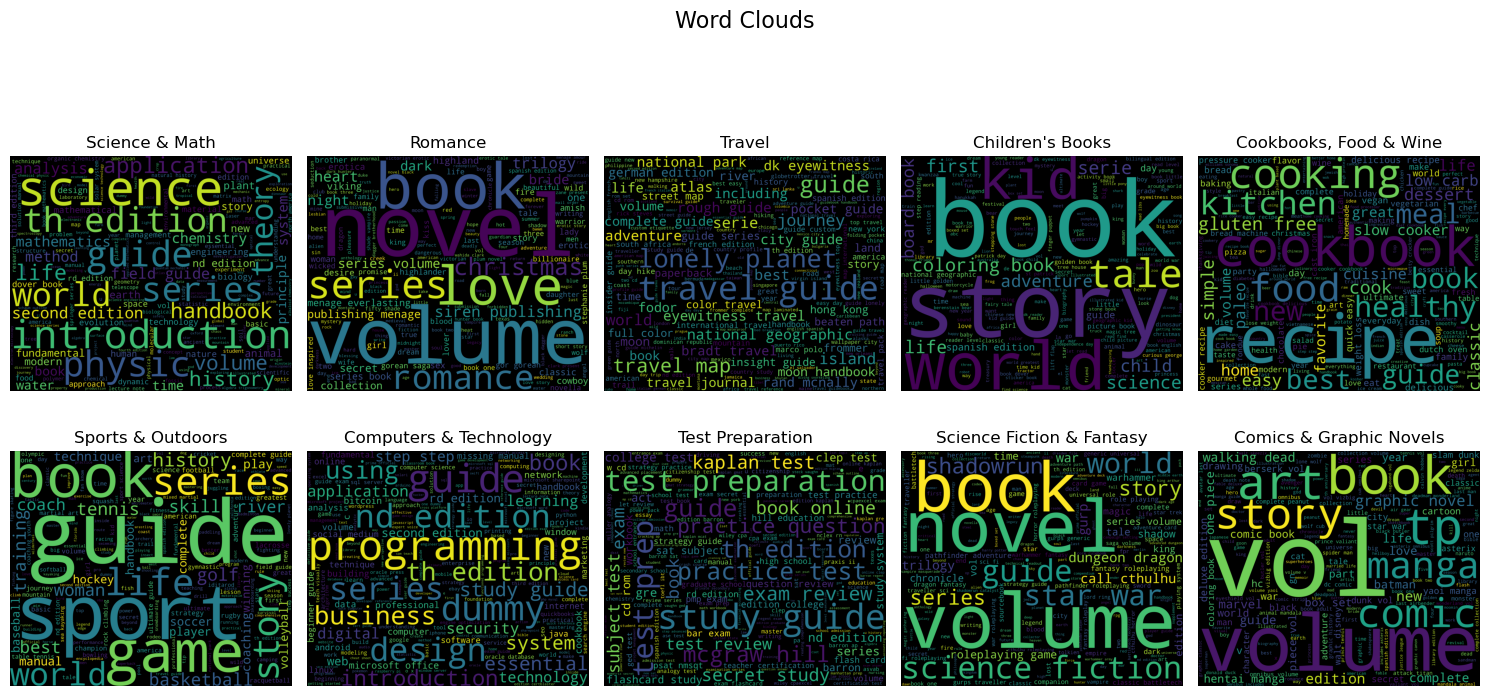

In [35]:
# plt.figure(1,figsize=(13, 13))
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Word Clouds', fontsize=16)

for i, ax in enumerate(axes.flat):

# for i in range(2):    
    ax.imshow(wordCloudList[i])
    ax.set_title(df['Category'].unique()[i])
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()
plt.savefig("wordcloud_full.png")


# Count every words

In [16]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

In [63]:
title_data = df['New_Title']
title_data_words = vectorizer.fit_transform(title_data)
title_data= vectorizer.get_feature_names_out()


In [64]:
title_data_test = df_test['New_Title']
title_data_words_test = vectorizer.fit_transform(title_data_test)
title_data_test= vectorizer.get_feature_names_out()


In [65]:
title_data

array(['aa', 'abc', 'abroad', ..., 'zombie', 'zone', 'zoo'], dtype=object)

In [66]:
title_data_test

array(['aa', 'aaa', 'abc', ..., 'zimbabwe', 'zombie', 'zoo'], dtype=object)

In [67]:
print (title_data_words_test.shape)


(7801, 2000)


In [109]:
dist = np.sum(title_data_words.toarray(), axis=0)
# for tag, count in zip(title_data, dist):
#     print (tag,count) 

In [110]:
dist_test = np.sum(title_data_words_test.toarray(), axis=0)
# for tag, count in zip(title_data_test, dist_test):
#     print (tag,count) 

In [123]:
word_title_count = pd.DataFrame(dist, columns=['word_count'])
word_title_count['word'] = pd.Series(title_data, index=word_title_count.index)


In [124]:
word_title_count_test = pd.DataFrame(dist_test, columns=['word_count'])
word_title_count_test['word'] = pd.Series(title_data_test, index=word_title_count_test.index)


In [125]:
word_title_count.head()

,word_count,word
0,64,aa
1,80,abc
2,77,abroad
3,47,absolute
4,72,academic


In [126]:
word_title_count_test.head()

,word_count,word
0,9,aa
1,14,aaa
2,5,abc
3,10,abroad
4,6,absolute


In [127]:
word_title_count= word_title_count[['word', 'word_count']].sort_values(by='word_count', ascending=False).reset_index(drop=True)
word_title_count_test= word_title_count_test[['word', 'word_count']].sort_values(by='word_count', ascending=False).reset_index(drop=True)


In [128]:
word_title_count_test.head(20)

,word,word_count
0,guide,1199
1,book,564
2,edition,556
3,travel,394
4,recipe,336
5,series,335
6,map,280
7,world,247
8,volume,244
9,new,229


In [129]:
word_title_count.head(20)


,word,word_count
0,guide,10636
1,book,5269
2,edition,5227
3,travel,3391
4,recipe,3257
5,series,2916
6,map,2632
7,volume,2234
8,world,2163
9,new,2079


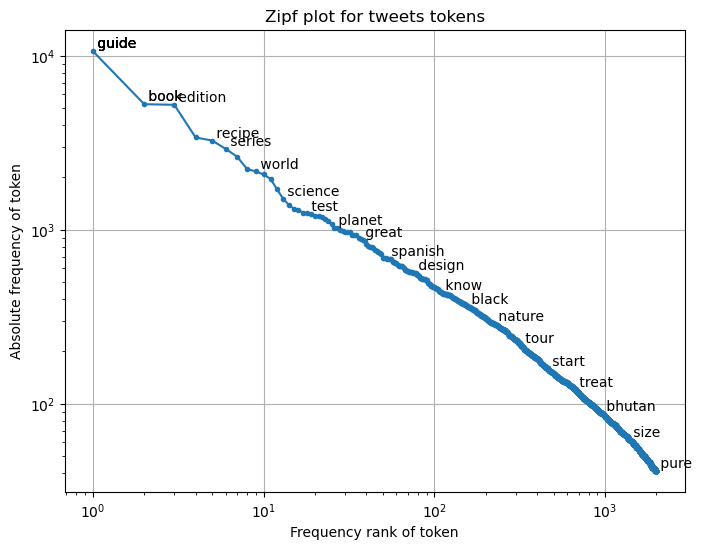

In [98]:
from pylab import *
counts = word_title_count['word_count'].to_numpy()
tokens = word_title_count['word']
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
# plt.ylim(1,10**4)
# plt.xlim(1,10**4)
loglog(ranks, frequencies, marker=".")
# plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

IndexError: index 2000 is out of bounds for axis 0 with size 2000

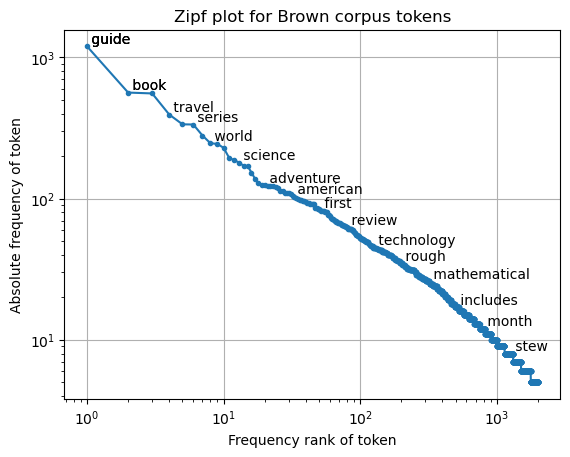

In [121]:
from pylab import *
# counts =  word_title_count['word_count'].to_numpy()
counts_test = word_title_count_test['word_count'].to_numpy()

# tokens =  word_title_count['word']
tokens_test =  word_title_count_test['word']

# ranks = arange(1, len(counts)+1)
ranks_test = arange(1, len(counts_test)+1)

# indices = argsort(-counts)
indices_test = argsort(-counts_test)

# frequencies = counts[indices]
frequencies_test = counts_test[indices_test]

# loglog(ranks, frequencies, marker=".", color="blue")

loglog(ranks_test, frequencies_test, marker=".")
# plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')

title("Zipf plot for Brown corpus tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)), 20).astype(int)):
    dummy = text(ranks_test[n], frequencies_test[n], " " + tokens_test[indices_test[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

show()

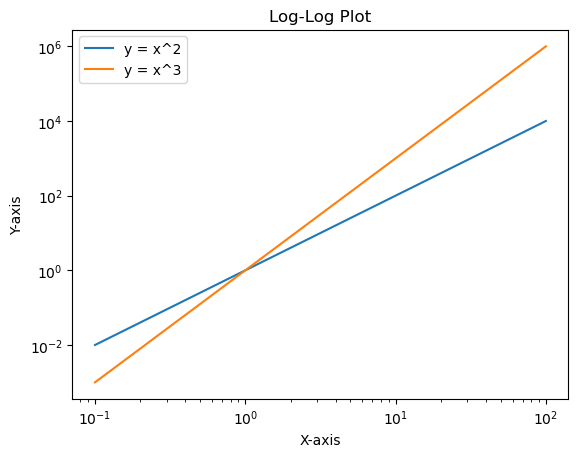

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.logspace(-1, 2, 100)
y1 = x**2
y2 = x**3

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first set of data with log-log scale
ax.loglog(x, y1, label='y = x^2')

# Plot the second set of data with log-log scale on the same axis
ax.loglog(x, y2, label='y = x^3')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Log-Log Plot')

# Display the legend
ax.legend()

# Show the plot
plt.show()


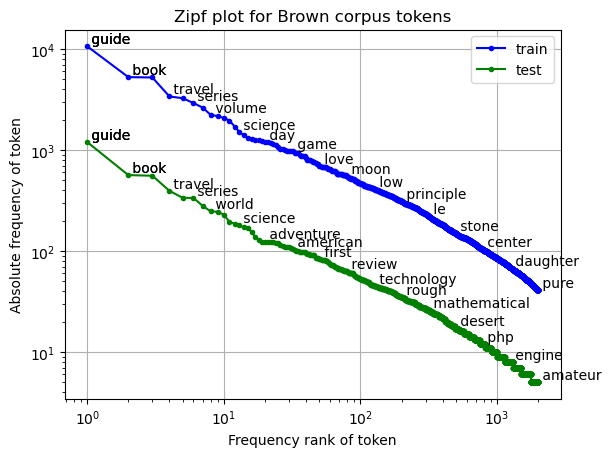

In [140]:
from pylab import *
counts =  word_title_count['word_count'].to_numpy()
counts_test = word_title_count_test['word_count'].to_numpy()

tokens =  word_title_count['word']
tokens_test =  word_title_count_test['word']

ranks = arange(1, len(counts)+1)
ranks_test = arange(1, len(counts_test)+1)

indices = argsort(-counts)
indices_test = argsort(-counts_test)

frequencies = counts[indices]
frequencies_test = counts_test[indices_test]

fig, ax = plt.subplots()

ax.loglog(ranks, frequencies, marker=".", color="blue", label="train")

ax.loglog(ranks_test, frequencies_test, marker=".", color="green", label="test")
# ax.plot([1,frequencies[0]],[frequencies[0],1],color='r')

ax.set_title("Zipf plot for Word corpus tokens")
ax.set_xlabel("Frequency rank of token")
ax.set_ylabel("Absolute frequency of token")
ax.grid(True)
ax.legend()

for n in list(logspace(-0.5, log10(len(counts)-2), 20).astype(int)):
    dummy = text(ranks_test[n], frequencies_test[n], " " + tokens_test[indices_test[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")


plt.show()

# Pie chart

In [2]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

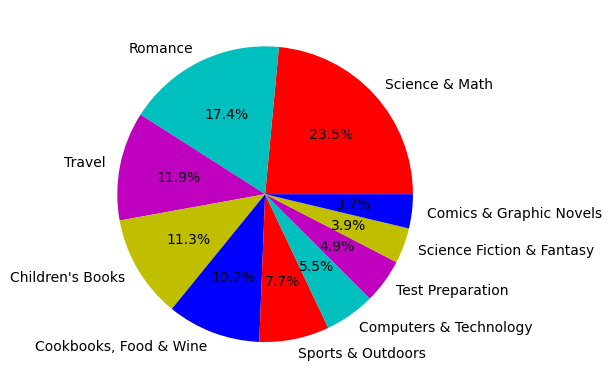

In [7]:
plt.pie(df['Category'].value_counts(),labels=df['Category'].unique(),colors=['r','c','m','y','b'],autopct="%0.1f%%")
plt.show

# Train


In [13]:
cv = CountVectorizer()
x_train = cv.fit_transform(corpus).toarray()
x_test = cv.transform(corpus_test).toarray()
y_train = df['Category'].values
y_test = df_test['Category'].values


In [22]:
import joblib
joblib.dump(cv, './checkpoint/count_vectorizer_data.joblib')


['./checkpoint/count_vectorizer_data.joblib']

In [14]:
# target = df['Category'].values
# target1 = df_test['Category'].values

# X_train, X_test, y_train, y_test = train_test_split(x_train, target, test_size=0.2, random_state=42)


In [15]:
nb = multinomialNaiveBayes(x_train, x_test, y_train, y_test)

In [16]:
print(f"Accuracy: {nb[0]}")

Accuracy: 0.7291666666666666


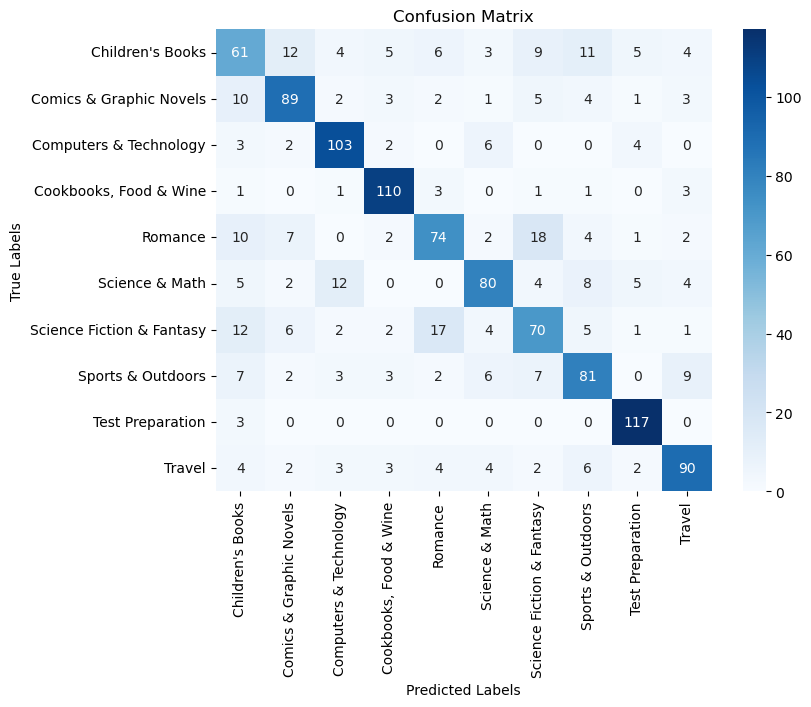

In [34]:
confusionMatrixHeatmap(nb[1], df['Category'].unique())

In [18]:
svm = svm(x_train, x_test, y_train, y_test)

In [19]:
print(f"Accuracy: {svm[0]}")

Accuracy: 0.6808333333333333


In [35]:
svm_rbf = svm_rbf(x_train, x_test, y_train, y_test)

In [36]:
print(f"Accuracy: {svm_rbf[0]}")

Accuracy: 0.6808333333333333


In [14]:
svm_rbf_c = svm_rbf_c(x_train, x_test, y_train, y_test)

In [15]:
print(f"Accuracy: {svm_rbf_c[0]}")

Accuracy: 0.6866666666666666


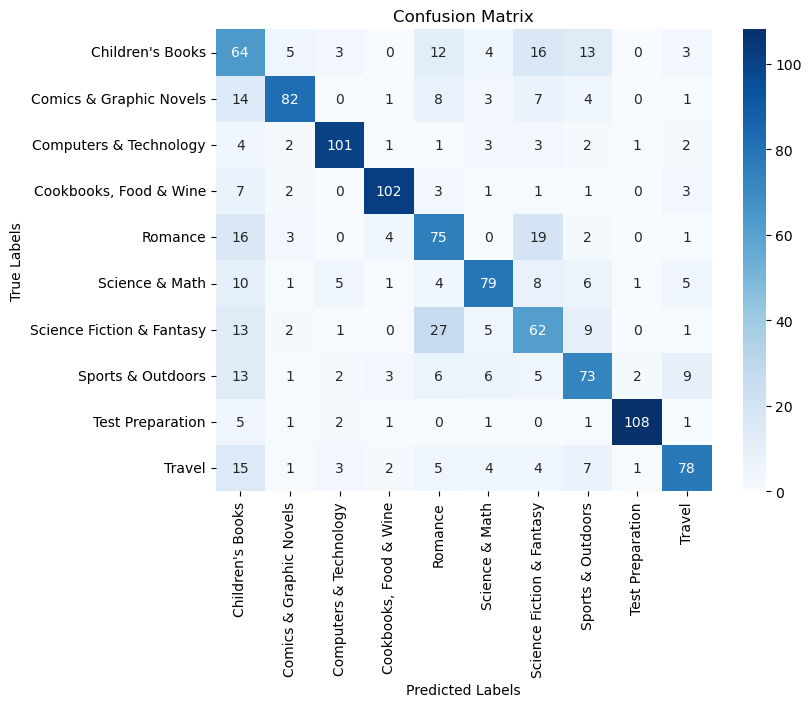

In [16]:
confusionMatrixHeatmap(svm_rbf_c[1], df['Category'].unique())

In [20]:
# from sklearn.naive_bayes import MultinomialNB
# classifier = MultinomialNB()
# classifier.fit(X_train, y_train)

# y_pred = classifier.predict(X_test)

# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

In [21]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # accuracy_real = accuracy_score(y_test, y_real_pred)
# # print(f"Accuracy: {accuracy_real}")

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# # print("Confusion Matrix:")
# # print(cm)

# # Classification Report
# report = classification_report(y_test, y_pred)
# print("Classification Report:")
# print(report)